In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy import io as spio
from tqdm import tqdm
import cv2
from sklearn import metrics


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Split Data

In [9]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ('\nElapsed time is ')
        print (str(time.time() - startTime_for_tictoc))
        print('seconds.\n')
    else:
        print ('\nToc: start time not set\n')

In [10]:
data= sio.loadmat('/Users/fernanda/Documents/Tese_Mestrado/GitHub/Plastic-Strain-Predictions/data/Sample_3/RDM_Sample_3.mat')
angles= data['RDM']['angles'][0][0]
Enn= data['RDM']['Strains'][0][0][0][0][5]
Etn= data['RDM']['Strains'][0][0][0][0][4]
Ett= data['RDM']['Strains'][0][0][0][0][3]
CM= data['RDM']['CM'][0][0]

indPred= CM==1
wndSize= 35
n,m = angles.shape

print('n=', n , 'm=', m )

stride= int((wndSize-1)/2)
ncases= sum(sum(CM[stride:n-stride,stride:m-stride]==1))

Y= np.zeros((ncases,5))
# X0= np.zeros((ncases, wndSize**2))
X0 = []
X1= np.zeros((ncases,1))

cnt=0
for i in range(0+stride,n-stride):
  for j in range(0+stride,m-stride):
    if CM[i,j] == 1:
      indX= range(i-stride,i+stride+1)
      indY= range(j-stride,j+stride+1)
      Maux = angles[indX, :][:, indY]
      row= [Enn[i,j], Etn[i,j], Ett[i,j],i,j]
      Y[cnt,:]= row
      # X0[cnt,:]= Maux.flatten()
      X0.append(Maux)
      X1[cnt,:]= angles[i,j]
      cnt= cnt+1
      prog=cnt/ncases*100

n= 405 m= 419


In [11]:
Y1=Y[:,1]

df = pd.DataFrame({'Angles': X1.flatten()}) 
df['Enn'] = Y[:,0].flatten()
df['Etn'] = Y[:,1].flatten()
df['Ett'] = Y[:,2].flatten()
df['i'] = Y[:,3].flatten()
df['j'] = Y[:,4].flatten()

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X0, df.iloc[:,1:4], test_size=0.3, random_state=42)

# Scaling
scaler_minmax = MinMaxScaler(feature_range=(0,1))
X_train = np.array(X_train).reshape(len(X_train), -1)
scaler_std = StandardScaler()
X_train = scaler_std.fit_transform(X_train)
X_train = scaler_minmax.fit_transform(X_train)
X_train = X_train.reshape(len(X_train), wndSize, wndSize)
print(X_train.shape)

X_test = np.array(X_test).reshape(len(X_test), -1)
X_test = scaler_std.transform(X_test)
X_test = scaler_minmax.transform(X_test)
X_test = X_test.reshape(len(X_test), wndSize, wndSize)
print(X_test.shape)


(12272, 35, 35)
(5260, 35, 35)


# Rede CNN

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

x =  np.expand_dims(X_train, axis=-1)

# Create an ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    # rotation_range=20,      # Rotate by up to 20 degrees
    # width_shift_range=0.2, # Shift horizontally by up to 20% of the image width
    # height_shift_range=0.2,# Shift vertically by up to 20% of the image height
    horizontal_flip=True,   # Horizontal flipping
    vertical_flip=True,     # Vertical flipping
    zoom_range=0.2,         # Zoom in/out by up to 20%
    # brightness_range=[0.8, 1.2],  # Adjust brightness
    # shear_range=0.2,        # Shear transformations
    fill_mode='nearest',     # How to fill empty areas after transformations
    featurewise_center=False,
    featurewise_std_normalization=False,
)

augmented_data = datagen.flow(x, y_train, batch_size=32)

In [20]:
augmented_x = []
augmented_y = []

# Iterate through the augmented data generator
for batch_data, batch_labels in augmented_data:
    augmented_x.append(batch_data)
    augmented_y.append(batch_labels)

    # Break the loop when you've generated enough augmented data
    if len(augmented_x) >= 5000:
        break

# Combine the augmented data with the original training data
augmented_x = np.vstack([x] + augmented_x)
augmented_y = np.vstack([y_train] + augmented_y)

# Shuffle the combined data
shuffled_indices = np.random.permutation(len(augmented_x))
augmented_x = augmented_x[shuffled_indices]
augmented_y = augmented_y[shuffled_indices]

In [21]:
# CNN model
model = keras.Sequential([
    layers.Input(shape=(35, 35, 1)), 
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='linear')  
])
model_aug = keras.Sequential([
    layers.Input(shape=(35, 35, 1)), 
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='linear')  
])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model_aug.compile(optimizer='adam', loss='mean_squared_error')

# Print a summary of the model's architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 33, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [22]:
# Train the model
batch_ = 64
epochs_ = 200
history = model.fit(X_train, y_train, epochs=epochs_, batch_size=batch_, validation_split=0.2, verbose=2)

Epoch 1/200


2023-10-20 13:58:11.870226: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


154/154 - 3s - loss: 1.5932e-04 - val_loss: 1.0925e-04 - 3s/epoch - 21ms/step
Epoch 2/200
154/154 - 3s - loss: 9.9620e-05 - val_loss: 9.2233e-05 - 3s/epoch - 19ms/step
Epoch 3/200
154/154 - 3s - loss: 8.6067e-05 - val_loss: 8.6951e-05 - 3s/epoch - 19ms/step
Epoch 4/200
154/154 - 3s - loss: 7.7405e-05 - val_loss: 8.3622e-05 - 3s/epoch - 19ms/step
Epoch 5/200
154/154 - 3s - loss: 6.9619e-05 - val_loss: 7.5553e-05 - 3s/epoch - 19ms/step
Epoch 6/200
154/154 - 3s - loss: 6.1812e-05 - val_loss: 6.8974e-05 - 3s/epoch - 18ms/step
Epoch 7/200
154/154 - 3s - loss: 5.4638e-05 - val_loss: 6.1919e-05 - 3s/epoch - 19ms/step
Epoch 8/200
154/154 - 3s - loss: 4.9237e-05 - val_loss: 5.9457e-05 - 3s/epoch - 19ms/step
Epoch 9/200
154/154 - 3s - loss: 4.5799e-05 - val_loss: 5.6105e-05 - 3s/epoch - 19ms/step
Epoch 10/200
154/154 - 3s - loss: 4.1283e-05 - val_loss: 5.3766e-05 - 3s/epoch - 18ms/step
Epoch 11/200
154/154 - 3s - loss: 3.7786e-05 - val_loss: 5.4210e-05 - 3s/epoch - 19ms/step
Epoch 12/200
154/154

In [23]:
# Train the model
history_aug = model_aug.fit(augmented_x, augmented_y, epochs=100, batch_size=32, validation_split=0.2, verbose=2)

Epoch 1/100
4302/4302 - 53s - loss: 1.0455e-04 - val_loss: 8.2847e-05 - 53s/epoch - 12ms/step
Epoch 2/100
4302/4302 - 53s - loss: 6.9152e-05 - val_loss: 6.1198e-05 - 53s/epoch - 12ms/step
Epoch 3/100
4302/4302 - 52s - loss: 5.5188e-05 - val_loss: 5.1184e-05 - 52s/epoch - 12ms/step
Epoch 4/100
4302/4302 - 52s - loss: 4.7340e-05 - val_loss: 4.6516e-05 - 52s/epoch - 12ms/step
Epoch 5/100
4302/4302 - 52s - loss: 4.1667e-05 - val_loss: 4.1976e-05 - 52s/epoch - 12ms/step
Epoch 6/100
4302/4302 - 53s - loss: 3.7428e-05 - val_loss: 3.9826e-05 - 53s/epoch - 12ms/step
Epoch 7/100
4302/4302 - 52s - loss: 3.4453e-05 - val_loss: 3.6940e-05 - 52s/epoch - 12ms/step
Epoch 8/100
4302/4302 - 53s - loss: 3.2269e-05 - val_loss: 3.8323e-05 - 53s/epoch - 12ms/step
Epoch 9/100
4302/4302 - 53s - loss: 3.0291e-05 - val_loss: 3.2122e-05 - 53s/epoch - 12ms/step
Epoch 10/100
4302/4302 - 53s - loss: 2.8546e-05 - val_loss: 3.2090e-05 - 53s/epoch - 12ms/step
Epoch 11/100
4302/4302 - 53s - loss: 2.7175e-05 - val_loss:

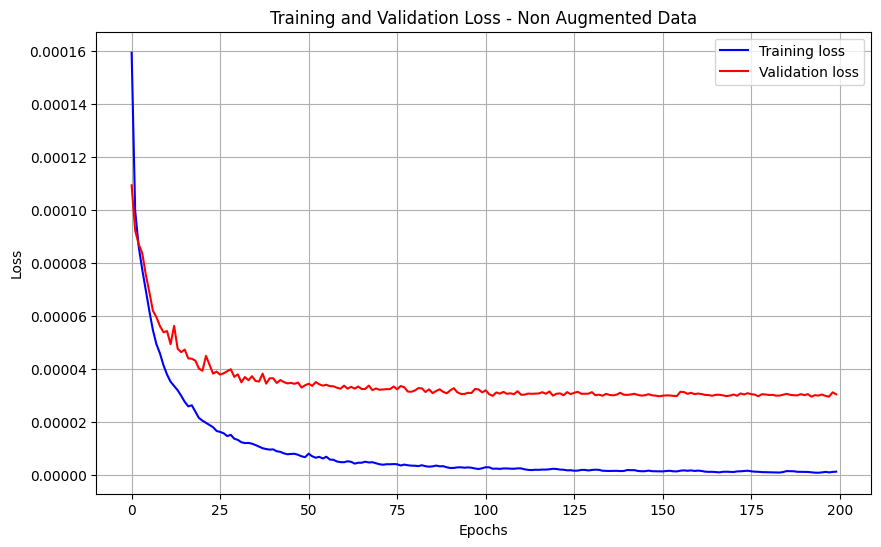

In [24]:
# Extraia os valores de loss do histórico
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crie um gráfico para visualizar as curvas de loss
epochs = range(0, len(train_loss))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss - Non Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

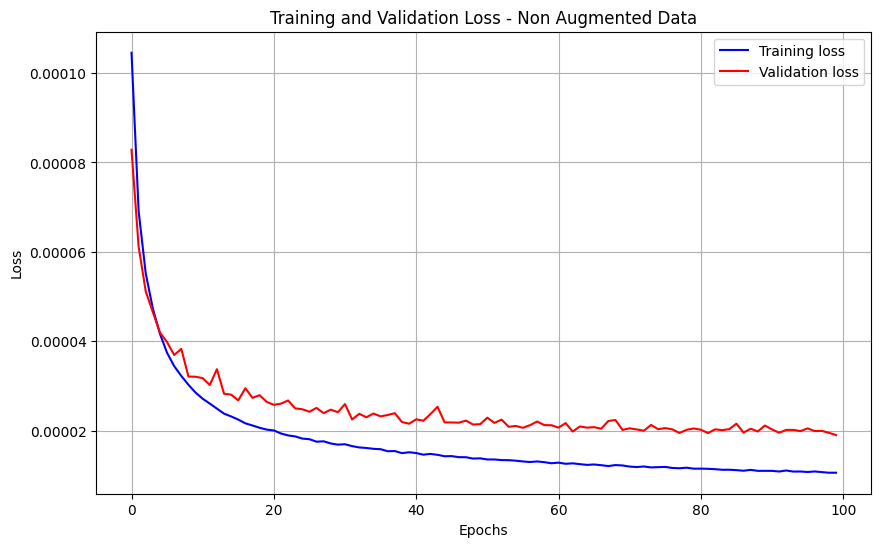

In [25]:
# Extraia os valores de loss do histórico
train_loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

# Crie um gráfico para visualizar as curvas de loss
epochs = range(0, len(train_loss))

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss - Non Augmented Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
y_hat = model.predict(X_test)
y_hat_aug = model_aug.predict(X_test)

165/165 [==============================] - 1s 4ms/step


In [27]:
PredDF = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)).rename(columns={"Enn": "y1","Etn": "y2","Ett": "y3"}),
                                      pd.DataFrame(y_hat,columns=['yh1','yh2','yh3'])],axis=1)

PredDF_aug = pd.concat([pd.DataFrame(y_test.reset_index(drop=True)).rename(columns={"Enn": "y1","Etn": "y2","Ett": "y3"}),
                                      pd.DataFrame(y_hat_aug,columns=['yh1','yh2','yh3'])],axis=1)

# Model Evaluation

In [28]:
PredDF.corr().iloc[:3,3:]

,yh1,yh2,yh3
y1,0.897415,-0.106016,-0.645755
y2,-0.080717,0.966188,0.172056
y3,-0.659383,0.197153,0.881883


In [29]:
PredDF_aug.corr().iloc[:3,3:]

,yh1,yh2,yh3
y1,0.920593,-0.120378,-0.689924
y2,-0.158881,0.972565,0.201305
y3,-0.671267,0.200910,0.908284


In [30]:
print('Resultados Holdout Enn')
print('')
print(metrics.r2_score(PredDF['y1'], PredDF['yh1']))
print('')
print('')
# plt.scatter(PredDF['y1'], PredDF['yh1'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

print('Resultados Holdout Etn')
print('')
print(metrics.r2_score(PredDF['y2'], PredDF['yh2']))
print('')
print('')
# plt.scatter(PredDF['y2'], PredDF['yh2'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()

print('Resultados Holdout Ett')
print('')
print(metrics.r2_score(PredDF['y3'], PredDF['yh3']))
print('')
print('')
# plt.scatter(PredDF['y3'], PredDF['yh3'])
# plt.xlabel('Actual')
# plt.ylabel('Predicted')
# plt.show()


print('PredDF_aug: Resultados Holdout Enn')
print('')
print(metrics.r2_score(PredDF_aug['y1'], PredDF_aug['yh1']))
print('')
print('')

print('PredDF_aug: Resultados Holdout Etn')
print('')
print(metrics.r2_score(PredDF_aug['y2'], PredDF_aug['yh2']))
print('')

print('')
print('PredDF_aug: Resultados Holdout Ett')
print('')
print(metrics.r2_score(PredDF_aug['y3'], PredDF_aug['yh3']))


Resultados Holdout Enn

0.8044774690440443


Resultados Holdout Etn

0.9325830736355003


Resultados Holdout Ett

0.7757535732403638


PredDF_aug: Resultados Holdout Enn

0.8462128114651006


PredDF_aug: Resultados Holdout Etn

0.9450242540534264


PredDF_aug: Resultados Holdout Ett

0.8223309120701355
